# **Spatial Patterns of insect Diversity in continetal Ecuador**

## **Completeness analysis**

Author: Daning Montaño - Ocampo

# **1. Packages and libraries**

In [143]:
library(dplyr)
library(ggplot2)
library(sf)
library(iNEXT)
library(tidyr)
library(vegan)
library(tibble)
#library(doParallel)
#

# 2. Load clean data and grids

In [144]:
insects_records = read.csv("Data/Records/insects_records_clean.csv")

# Transform to sf object
insects_records_sf = st_as_sf(insects_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)


In [145]:
insects_records_sf

Simple feature collection with 70917 features and 17 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.3037 ymin: -5.911483 xmax: -74.40273 ymax: 2.00376
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id                         occurrenceID     basisOfRecord verbatimEventDate                                identifiedBy
1          2          BNDB  BNDB_10611 d7acf7c1-ac14-410f-a636-bb6568b11e49 PreservedSpecimen        1987-08-06                                 Dressler R.
2          4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb PreservedSpecimen        2015-07-04                                Bonifacii R.
3          6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355 PreservedSpecimen        2015-07-04                                Bonifacii R.
4          8          BNDB  BNDB_10617 431219fe-57b1-489b-aeba-cf5ea796076d PreservedSpecimen        2015-07-04                                Bonifacii R.
5   

In [146]:
grid_10km = st_read("Data/shp/grid_10km.shp")
grid_10km$id_10km = grid_10km$id
grid_10km = grid_10km %>% select(-id)
grid_2km = st_read("Data/shp/grid_2km.shp")
grid_2km$id_2km = grid_2km$id
grid_2km = grid_2km %>% select(-id)

Reading layer `grid_10km' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\grid_10km.shp' using driver `ESRI Shapefile'
Simple feature collection with 7268 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -81.32114 ymin: -6.003704 xmax: -74.19902 ymax: 2.31959
Geodetic CRS:  WGS 84
Reading layer `grid_2km' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\grid_2km.shp' using driver `ESRI Shapefile'
Simple feature collection with 116350 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -81.01119 ymin: -5.022759 xmax: -75.15773 ymax: 1.454985
Geodetic CRS:  WGS 84


# 3. Join points to grids

We are going to extract the ID of each square in the 10 km grid using the 2 km grid, so that we can link them. 

First we extract centroids from grid 2km to avoid problems with the boundaries of the grid

In [147]:
centroides_2km = grid_2km %>% st_centroid()
centroides_2km

Warning message:
st_centroid assumes attributes are constant over geometries 


Simple feature collection with 116350 features and 5 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.00216 ymin: -5.013713 xmax: -75.16678 ymax: 1.445938
Geodetic CRS:  WGS 84
First 10 features:
       left      top    right   bottom id_2km                   geometry
1  498760.1 10160820 500760.1 10158820      1 POINT (-81.00216 1.445938)
2  498760.1 10158820 500760.1 10156820      2 POINT (-81.00216 1.427843)
3  498760.1 10156820 500760.1 10154820      3 POINT (-81.00216 1.409749)
4  498760.1 10154820 500760.1 10152820      4 POINT (-81.00216 1.391654)
5  498760.1 10152820 500760.1 10150820      5  POINT (-81.00216 1.37356)
6  498760.1 10150820 500760.1 10148820      6 POINT (-81.00216 1.355465)
7  498760.1 10148820 500760.1 10146820      7 POINT (-81.00216 1.337371)
8  498760.1 10146820 500760.1 10144820      8 POINT (-81.00216 1.319276)
9  498760.1 10144820 500760.1 10142820      9 POINT (-81.00216 1.301182)
10 498760.1 10142820 500760.1 10140820     10 POINT 

We create a spatial features with id froms 10 km grids

In [148]:
centroids_2km_with_10km_id <- st_join(centroides_2km, 
  grid_10km %>% select(id_10km), 
  join = st_intersects)

Join the information extracted by centroids with the original grid_2km using the id_2km

In [149]:
grid_2km$id_10km = centroids_2km_with_10km_id$id_10km

By locating the points, we will extract ID information from the grid tables. This allows us to work on the analyses and simply join the results to the grid, making the process more efficient.

In [150]:
recors_grid_2km <- st_join(
  insects_records_sf,
  grid_2km %>% select(id_2km, id_10km),   
  join = st_within                              # inside polygons
)

# 4. Records per 10 km grid

We calculate the number of records per 10 km grid usind id_10km

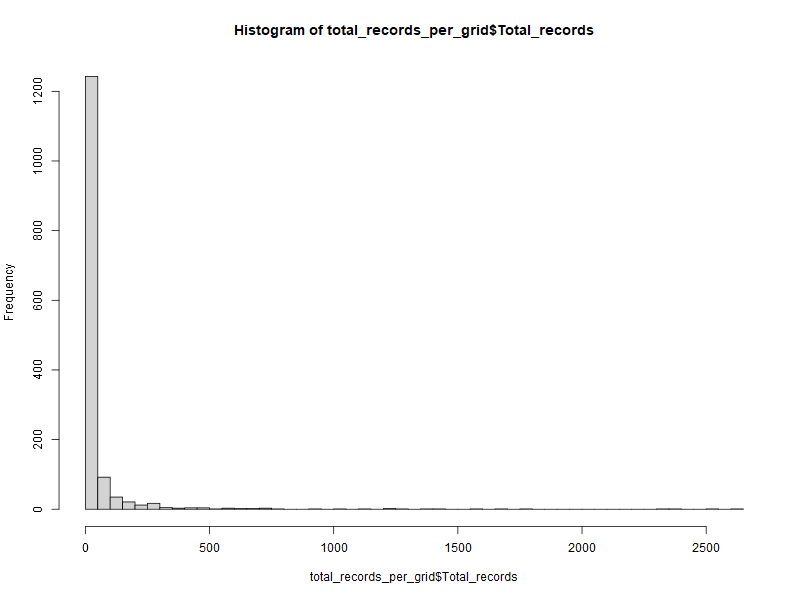

In [151]:
total_records_per_grid = recors_grid_2km %>%
  as.data.frame() %>%
  group_by(id_10km)%>%
  summarise(Total_records = n()) %>%
  as.data.frame()
hist(total_records_per_grid$Total_records, breaks = 50)

Join results to 10 km grid

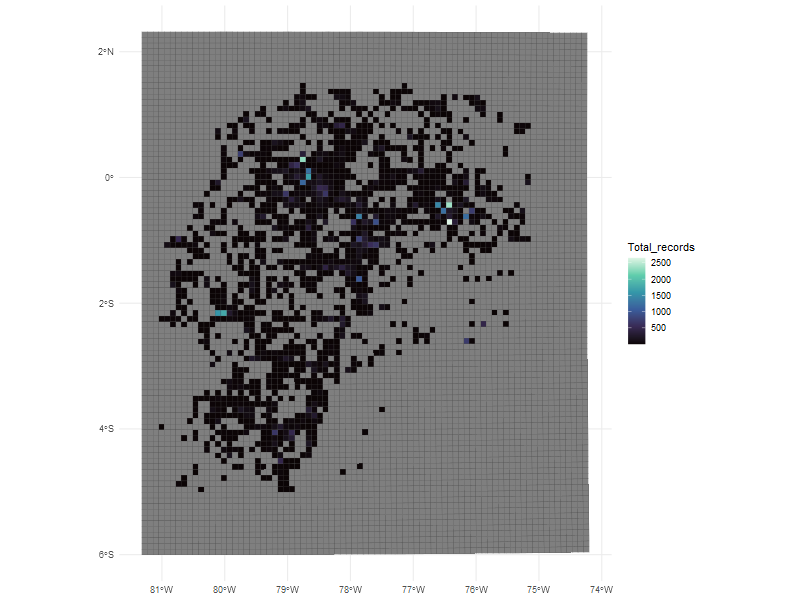

In [152]:
grid_10km = grid_10km%>% 
  left_join(total_records_per_grid, by = "id_10km")

ggplot(grid_10km) +
  geom_sf(aes(fill = Total_records), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

# 5. Sp per 10 km grid

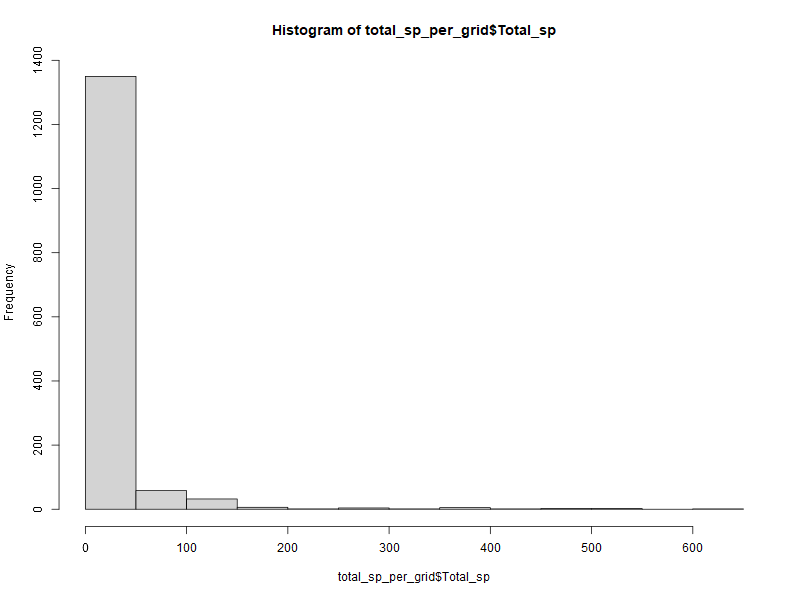

In [153]:
total_sp_per_grid = recors_grid_2km %>%
  as.data.frame() %>%
  group_by(id_10km)%>%
  distinct(scientificName) %>%
  summarise(Total_sp = n()) %>%
  as.data.frame()
hist(total_sp_per_grid$Total_sp)

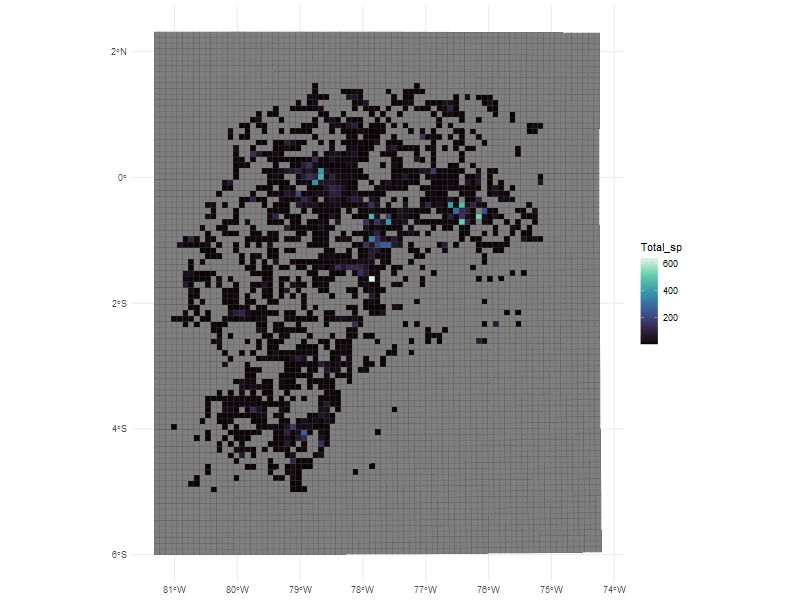

In [154]:
grid_10km = grid_10km%>% 
  left_join(total_sp_per_grid, by = "id_10km")
ggplot(grid_10km) +
  geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.1) +
  scale_fill_viridis_c(option = "mako") +
  theme_minimal()

## 5.1 Correlaction records x sp

In [155]:
cor(grid_10km$Total_records, grid_10km$Total_sp, method = "spearman", use = "complete.obs")

[1] 0.9527846

Warning messages:
1: Removed 5806 rows containing non-finite outside the scale range (`stat_smooth()`). 
2: Removed 5806 rows containing missing values or values outside the scale range (`geom_point()`). 


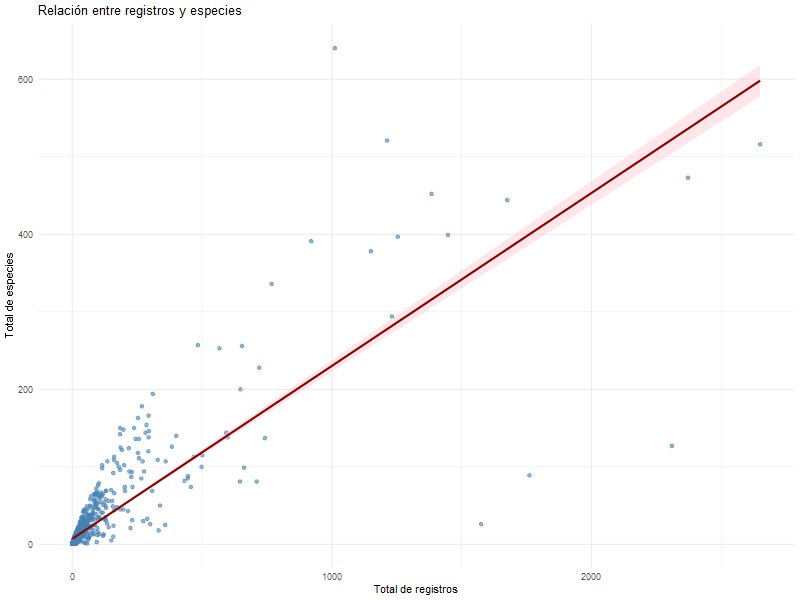

`geom_smooth()` using formula = 'y ~ x'

In [156]:
ggplot(grid_10km, aes(x = Total_records, y = Total_sp)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", fill = "pink") +
  theme_minimal() +
  labs(
    x = "Total de registros",
    y = "Total de especies",
    title = "Relación entre registros y especies"
  )

# 6. Sampling Completness

## 6.1. Completness - Country level

Calculate completnes for all country using incidens data and each 10 km cell is a unit

In [157]:
ecu_incidens_matrix <- recors_grid_2km %>%
  as.data.frame() %>%
  distinct(id_10km, scientificName) %>%          # 1 por unidad-especie
  mutate(val = 1L) %>%
  pivot_wider(names_from = scientificName, values_from = val, values_fill = 0) %>%
  arrange(id_10km)
ids_unidades_ecu <- ecu_incidens_matrix$id_10km

# Quitamos la columna de IDs para dejar solo 0/1 por especie
incidences_ecu_df <- ecu_incidens_matrix %>% dplyr::select(-id_10km)

# Matriz of incidences - iNext
inext_in_ecu <- list(ensamblaje = as.data.frame(t(incidences_ecu_df)))




Use iNEXT funtion to calculate the sampling coverage in Ecuador, an only extract richness (q=0) and sampling coverage

In [158]:
result_inext_ecu <- iNEXT(inext_in_ecu, q = 0, datatype = "incidence_raw", se = TRUE, conf = 0.95,nboot= 100 )
result_inext_ecu

Compare 1 assemblages with Hill number order q = 0.
$class: iNEXT

$DataInfo: basic data information
  Assemblage    T     U S.obs    SC   Q1   Q2  Q3  Q4  Q5  Q6  Q7  Q8 Q9 Q10
1 ensamblaje 1463 26076  8071 0.835 4304 1378 701 374 279 185 140 105 82  86

$iNextEst: diversity estimates with rarefied and extrapolated samples.
$size_based (LCL and UCL are obtained for fixed size.)

   Assemblage    t        Method Order.q          qD      qD.LCL      qD.UCL         SC     SC.LCL     SC.UCL
1  ensamblaje    1   Rarefaction       0    17.82365    17.61884    18.02846 0.01070479 0.01021857 0.01119101
10 ensamblaje  731   Rarefaction       0  5448.48409  5388.32239  5508.64579 0.74909493 0.74489385 0.75329601
20 ensamblaje 1463      Observed       0  8071.00000  7969.03225  8172.96775 0.83501627 0.83082399 0.83920855
30 ensamblaje 2156 Extrapolation       0  9829.07026  9685.25474  9972.88578 0.87819889 0.87355238 0.88284540
40 ensamblaje 2926 Extrapolation       0 11248.36435 11053.54453 11

In [161]:
info_inext_ecu <- DataInfo(inext_in_ecu, datatype = "incidence_raw")  # columna SC = sample coverage; T = # unidades de muestreo
info_inext_ecu


Warning message:
In ggiNEXT.iNEXT(result_inext_ecu, type = 2) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


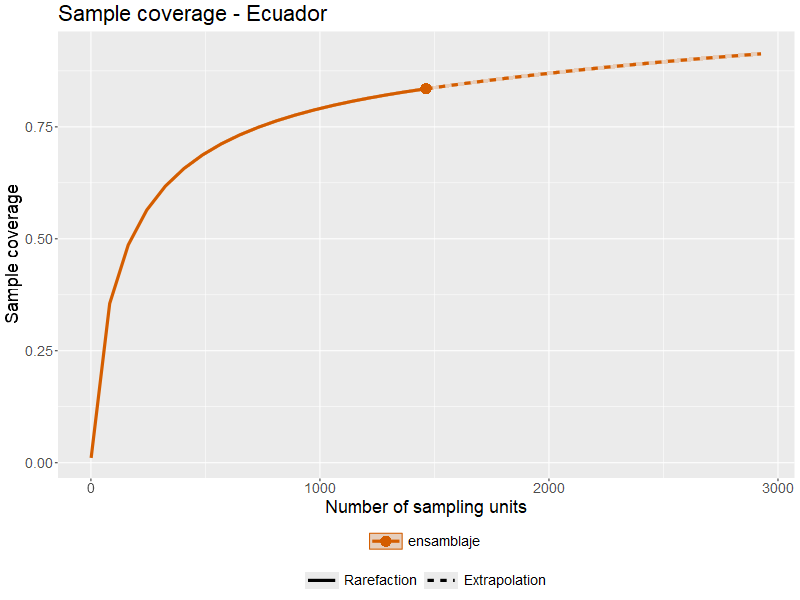

In [162]:
plot_units_sc <- ggiNEXT(result_inext_ecu, type = 2) + labs(title = "Sample coverage - Ecuador")
plot_units_sc

Warning message:
In ggiNEXT.iNEXT(result_inext_ecu, type = 1) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


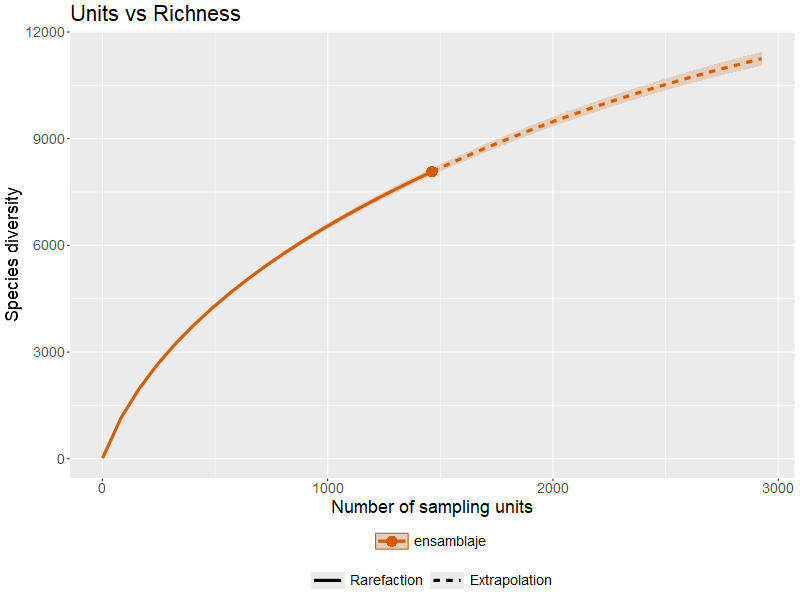

In [163]:
plot_units_richness <- ggiNEXT(result_inext_ecu, type = 1) + labs(title = "Units vs Richness")
plot_units_richness

## 6.2. Grid

### 6.2.1 Sample coverage

Calculamos la completitud de la muestra usando el paquete iNEXT. Para esto se usarán las incidencias de las especies, y dentro de cada grid de 10 km, cada celda de 2 km es una unidad, en done evaluamos como el incluir unidades cambia la cobertura de la muestra

In [165]:

# Unique 10-km IDs
cid_10km <- unique(recors_grid_2km$id_10km)

# Results container
results_s_cov <- data.frame(
  id_10km = integer(),
  Samplig_coverage = numeric(),  # observed SC
  n_units = numeric(),           # T
  n_incidences = numeric(),      # U
  sp_obs = numeric(),            # S.obs
  Q1 = numeric(),
  Q2 = numeric(),
  sc_ext = numeric(),            # SC at max coverage row
  n_units_ext = numeric(),       # t at max coverage row
  sp_ext = numeric(),            # qD at max coverage row
  stringsAsFactors = FALSE
)

# Progress bar
pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
count <- 0

for (i in cid_10km) {

  # Build incidence matrix (rows = id_2km, cols = species, 0/1)
  records_by_id <- recors_grid_2km %>% dplyr::filter(id_10km == i)

  incidens_matrix_2km <- records_by_id %>%
    as.data.frame() %>%
    dplyr::distinct(id_2km,  scientificName) %>%
    dplyr::mutate(val = 1L) %>%
    tidyr::pivot_wider(names_from =  scientificName, values_from = val, values_fill = 0) %>%
    dplyr::arrange(id_2km)

  ids_unidades_2km <- incidens_matrix_2km$id_2km
  incidens_matrix_2km_df <- incidens_matrix_2km %>% dplyr::select(-id_2km)

  # Ensure numeric 0/1 for iNEXT
  incidens_matrix_2km_df[] <- lapply(incidens_matrix_2km_df, as.numeric)

  # iNEXT input
  inext_grid_2km <- list(ensamblaje = as.data.frame(t(incidens_matrix_2km_df)))

  # Run iNEXT and extract metrics
  sampl_result <- tryCatch({
    result_inext_2km_grid <- iNEXT(
      inext_grid_2km,
      q = 0,
      datatype = "incidence_raw",
      se = FALSE
    )

    sc_obs      <- result_inext_2km_grid$DataInfo$SC
    n_units_obs <- result_inext_2km_grid$DataInfo$T
    n_incid     <- result_inext_2km_grid$DataInfo$U
    sp_obs      <- result_inext_2km_grid$DataInfo$S.obs
    Q1          <- result_inext_2km_grid$DataInfo$Q1
    Q2          <- result_inext_2km_grid$DataInfo$Q2

    cb <- result_inext_2km_grid$iNextEst$coverage_based
    sc_ext      <- if (!is.null(cb)) tail(cb$SC, 1) else NA_real_
    n_units_ext <- if (!is.null(cb)) tail(cb$t,  1) else NA_real_
    sp_ext      <- if (!is.null(cb)) tail(cb$qD, 1) else NA_real_

    data.frame(
      Samplig_coverage = sc_obs,
      n_units = n_units_obs,
      n_incidences = n_incid,
      sp_obs = sp_obs,
      Q1 = Q1,
      Q2 = Q2,
      sc_ext = sc_ext,
      n_units_ext = n_units_ext,
      sp_ext = round(sp_ext, 0),
      stringsAsFactors = FALSE
    )
  }, error = function(e) {
    data.frame(
      Samplig_coverage = NA_real_,
      n_units = NA_real_,
      n_incidences = NA_real_,
      sp_obs = NA_real_,
      Q1 = NA_real_,
      Q2 = NA_real_,
      sc_ext = NA_real_,
      n_units_ext = NA_real_,
      sp_ext = NA_real_,
      stringsAsFactors = FALSE
    )
  })

  # Append row for this 10-km cell
  results_s_cov <- rbind(
    results_s_cov,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

  count <- count + 1
  setTxtProgressBar(pb, count)
}

# Close progress bar
close(pb)



  |=============================================================================================================================================================| 100%

There were 50 or more warnings (use warnings() to see the first 50)


In [166]:


cid_10km <- unique(recors_grid_2km$id_10km)

results_s_cov <- data.frame(
  id_10km = integer(),
  Sampling_coverage = numeric(),
  n_individuals = numeric(),
  sp_obs = numeric(),
  f1 = numeric(),
  f2 = numeric(),
  sc_ext = numeric(),
  n_ind_ext = numeric(),
  sp_ext = numeric(),
  stringsAsFactors = FALSE
)

pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
count <- 0

for (i in cid_10km) {
  
  # eliminar geometría sf
  records_by_id <- recors_grid_2km %>% 
    filter(id_10km == i) %>% 
    st_drop_geometry()
  
  # matriz de abundancia por especie
  abund_matrix <- records_by_id %>%
    group_by(id_2km, scientificName) %>%
    summarise(abund = n(), .groups = "drop") %>%
    pivot_wider(
      names_from  = scientificName,
      values_from = abund,
      values_fill = 0
    ) %>%
    arrange(id_2km)
  
  abund_df <- abund_matrix %>% select(-id_2km)
  
  abund_df[] <- lapply(abund_df, function(x) {
    x <- suppressWarnings(as.numeric(x))
    x[is.na(x)] <- 0
    x
  })
  
  abund_total <- colSums(abund_df)
  
  inext_input <- list(ensamblaje = abund_total)
  
  sampl_result <- tryCatch({
    
    result_inext <- iNEXT(
      inext_input,
      q = 0,
      datatype = "abundance",
      se = FALSE
    )
    
    sc_obs <- result_inext$DataInfo$SC
    n_ind  <- result_inext$DataInfo$n
    sp_obs <- result_inext$DataInfo$S.obs
    f1     <- result_inext$DataInfo$f1
    f2     <- result_inext$DataInfo$f2
    
    sb <- result_inext$iNextEst$size_based
    
    sc_ext    <- if (!is.null(sb)) tail(sb$SC, 1) else NA_real_
    n_ind_ext <- if (!is.null(sb)) tail(sb$m,  1) else NA_real_
    sp_ext    <- if (!is.null(sb)) tail(sb$qD, 1) else NA_real_
    
    data.frame(
      id_10km = i,
      Sampling_coverage = sc_obs,
      n_individuals = n_ind,
      sp_obs = sp_obs,
      f1 = f1,
      f2 = f2,
      sc_ext = sc_ext,
      n_ind_ext = n_ind_ext,
      sp_ext = round(sp_ext, 0),
      stringsAsFactors = FALSE
    )
    
  }, error = function(e) {
    data.frame(
      id_10km = i,
      Sampling_coverage = NA_real_,
      n_individuals = NA_real_,
      sp_obs = NA_real_,
      f1 = NA_real_,
      f2 = NA_real_,
      sc_ext = NA_real_,
      n_ind_ext = NA_real_,
      sp_ext = NA_real_,
      stringsAsFactors = FALSE
    )
  })
  
  results_s_cov <- rbind(results_s_cov, sampl_result)
  
  count <- count + 1
  setTxtProgressBar(pb, count)
}

close(pb)

results_s_cov



  |=============================================================================================================================================================| 100%

There were 50 or more warnings (use warnings() to see the first 50)


### 6.2.2. Species accumulation curve - Slope

In [168]:
# Unique 10-km IDs
cid_10km <- unique(recors_grid_2km$id_10km)

# Results container
results_slope <- data.frame(
  id_10km = integer(),
  slope = numeric()  # observed SC
)

# Progress bar
#pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
#count <- 0

for (i in cid_10km) {

  # Build incidence matrix (rows = id_2km, cols = species, 0/1)
  records_by_id <- recors_grid_2km %>% dplyr::filter(id_10km == i)

  incidens_matrix_2km <- records_by_id %>%
    as.data.frame() %>%
    dplyr::distinct(id_2km, specificEpithet) %>%
    dplyr::mutate(val = 1L) %>%
    tidyr::pivot_wider(names_from = specificEpithet, values_from = val, values_fill = 0) %>%
    dplyr::arrange(id_2km)

  ids_unidades_2km <- incidens_matrix_2km$id_2km
  incidens_matrix_2km_df <- incidens_matrix_2km %>% dplyr::select(-id_2km)

  # Ensure numeric 0/1 for iNEXT
  incidens_matrix_2km_df[] <- lapply(incidens_matrix_2km_df, as.numeric)

  # iNEXT input
  inext_grid_2km <- as.data.frame(incidens_matrix_2km_df)

  # Run iNEXT and extract metrics
  sampl_result <- tryCatch({
    result_specum_2km_grid <- 
      #max_permutations = factorial(nrow(inext_grid_2km))
      specaccum(inext_grid_2km, method = "random", permutations = 200)
    

    slope = tail(result_specum_2km_grid$richness, 1) - result_specum_2km_grid$richness[length(result_specum_2km_grid$richness) - 1]

    data.frame(
      slope = slope,
      stringsAsFactors = FALSE
    )
  }, error = function(e) {
    data.frame(
      slope = slope,
      stringsAsFactors = FALSE
    )
  })

  # Append row for this 10-km cell
  results_slope <- rbind(
    results_slope,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

 # count <- count + 1
  #setTxtProgressBar(pb, count)
}

# Close progress bar
#close(pb)

'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
Set of permutations < 'minperm'. Generating entire set.
no actual accumulation since only one site provided
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
Set of permutations < 'minperm'. Generating entire set.
Set of permutations < 'minperm'. Gener

In [169]:
head(results_slope)

   id_10km     slope
1     1606  1.000000
11    2228  7.168067
12    2508 11.220000
13    2868  7.008403
14    4814  3.375000
15    4907  2.170000

### 6.2.3. Sample completeness - Clench

In [170]:
# Unique 10-km IDs
cid_10km <- unique(recors_grid_2km$id_10km)

# Results container (keep original name/shape, now storing completeness)
results_completeness <- data.frame(
  id_10km = integer(),
  completeness = numeric()  # %
)

# Progress bar (kept commented to preserve your structure)
# pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
# count <- 0

for (i in cid_10km) {

  # Build incidence matrix (rows = id_2km, cols = specificEpithet, values = 0/1)
  records_by_id <- recors_grid_2km %>% dplyr::filter(id_10km == i)

  incidens_matrix_2km <- records_by_id %>%
    as.data.frame() %>%
    dplyr::distinct(id_2km, specificEpithet) %>%
    dplyr::mutate(val = 1L) %>%
    tidyr::pivot_wider(
      names_from  = specificEpithet,
      values_from = val,
      values_fill = 0
    ) %>%
    dplyr::arrange(id_2km)

  ids_unidades_2km <- incidens_matrix_2km$id_2km
  incidens_matrix_2km_df <- incidens_matrix_2km %>% dplyr::select(-id_2km)

  # Ensure numeric 0/1
  incidens_matrix_2km_df[] <- lapply(incidens_matrix_2km_df, as.numeric)

  # Input df
  inext_grid_2km <- as.data.frame(incidens_matrix_2km_df)

  # Compute completeness via Clench on specaccum curve
  sampl_result <- tryCatch({

    # Species accumulation (random average over permutations)
    result_specum_2km_grid <-
      specaccum(inext_grid_2km, method = "random", permutations = 200)

    # Data for fit
    x <- result_specum_2km_grid$sites       # effort (accumulated units)
    y <- result_specum_2km_grid$richness    # accumulated richness
    Sobs <- tail(y, 1)

    # Robust linear start: x/S ≈ 1/a + (b/a)*x
    xy <- x / y
    ok <- is.finite(xy) & is.finite(x) & is.finite(y) & (y > 0)

    if (sum(ok) >= 2) {
      lin_fit <- lm(xy[ok] ~ x[ok])
      c0 <- coef(lin_fit)[1]         # ~ 1/a
      c1 <- coef(lin_fit)[2]         # ~ b/a
      a0 <- if (is.finite(c0) && c0 > 0) 1 / c0 else max(y, na.rm = TRUE)
      b0 <- if (is.finite(c1)) c1 * a0 else 0.1
    } else {
      a0 <- max(y, na.rm = TRUE); b0 <- 0.1
    }

    a0 <- max(a0, .Machine$double.eps)
    b0 <- max(b0, .Machine$double.eps)

    # Reparameterize to enforce a>0, b>0 (stable when ~65% completeness)
    fit <- nls(
      y ~ (exp(aa) * x) / (1 + exp(bb) * x),
      start = list(aa = log(a0), bb = log(b0)),
      control = nls.control(maxiter = 200, tol = 1e-08, minFactor = 1/2^20)
    )

    # Extract parameters and compute S_inf = a/b
    cf <- coef(fit)
    a  <- exp(as.numeric(cf["aa"]))
    b  <- exp(as.numeric(cf["bb"]))
    Sinf <- a / b

    completeness <- if (is.finite(Sinf) && Sinf > 0) 100 * (Sobs / Sinf) else NA_real_
    if (is.finite(completeness)) completeness <- max(0, min(100, completeness))

    data.frame(
      completeness = as.numeric(completeness),
      stringsAsFactors = FALSE
    )

  }, error = function(e) {
    data.frame(
      completeness = NA_real_,
      stringsAsFactors = FALSE
    )
  })

  # Append row for this 10-km cell
  results_completeness <- rbind(
    results_completeness,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

  # count <- count + 1
  # setTxtProgressBar(pb, count)
}

# Close progress bar
# close(pb)


'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
Set of permutations < 'minperm'. Generating entire set.
no actual accumulation since only one site provided
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
'nperm' >= set of all permutations: complete enumeration.
Set of permutations < 'minperm'. Generating entire set.
Set of permutations < 'minperm'. Generating entire set.
Set of permutations < 'minperm'. Gener

In [175]:
head(results_completeness)

  id_10km completeness
1    1606           NA
2    2228           NA
3    2508     20.82889
4    2868           NA
5    4814     25.92737
6    4907           NA

### 6.2.4. Ratio Records / Species

In [176]:
ratio_RG =  data.frame(id_10km = grid_10km$id_10km, ratio_RG = grid_10km$Total_records/grid_10km$Total_sp)
ratio_RG

    id_10km ratio_RG
1         1       NA
2         2       NA
3         3       NA
4         4       NA
5         5       NA
6         6       NA
7         7       NA
8         8       NA
9         9       NA
10       10       NA
11       11       NA
12       12       NA
13       13       NA
14       14       NA
15       15       NA
16       16       NA
17       17       NA
18       18       NA
19       19       NA
20       20       NA
21       21       NA
22       22       NA
23       23       NA
24       24       NA
25       25       NA
26       26       NA
27       27       NA
28       28       NA
29       29       NA
30       30       NA
31       31       NA
32       32       NA
33       33       NA
34       34       NA
35       35       NA
36       36       NA
37       37       NA
38       38       NA
39       39       NA
40       40       NA
41       41       NA
42       42       NA
43       43       NA
44       44       NA
45       45       NA
46       46       NA
47       47  

### 6.2.4  Join Sample covergate with 10 km grid

In [202]:
results_s_cov

    id_10km Sampling_coverage n_individuals sp_obs  f1  f2    sc_ext n_ind_ext sp_ext
1      1606            0.4857             7      5   4   0 0.7540187        14      8
2      2228            0.6854            69     38  22  10 0.8741535       138     52
3      2508            0.8720           593    144  76  23 0.9301537      1186    201
4      2868            0.3373            45     36  30   4 0.4951084        90     62
5      4814            0.6619           109     55  37   8 0.7812861       218     85
6      4907            0.4218            22     17  13   3 0.6416026        44     27
7      3185            0.6250             4      3   2   1 0.8813477         8      4
8      2145            0.5764           106     60  45   5 0.6614191       212    100
9      4815            0.8736          1447    399 183  81 0.9478672      2894    520
10     4999            0.9128          2372    473 207  84 0.9612611      4744    615
11     3364            1.0000            31      4   1

In [177]:
results_sampling_effor = results_s_cov %>%
  left_join(results_slope, by = "id_10km") %>%
  left_join(results_completeness, by = "id_10km")%>%
  left_join(ratio_RG, by = "id_10km") 

head(results_sampling_effor)

  id_10km Sampling_coverage n_individuals sp_obs f1 f2    sc_ext n_ind_ext sp_ext     slope completeness ratio_RG
1    1606            0.4857             7      5  4  0 0.7540187        14      8  1.000000           NA 1.400000
2    2228            0.6854            69     38 22 10 0.8741535       138     52  7.168067           NA 1.815789
3    2508            0.8720           593    144 76 23 0.9301537      1186    201 11.220000     20.82889 4.118056
4    2868            0.3373            45     36 30  4 0.4951084        90     62  7.008403           NA 1.250000
5    4814            0.6619           109     55 37  8 0.7812861       218     85  3.375000     25.92737 1.981818
6    4907            0.4218            22     17 13  3 0.6416026        44     27  2.170000           NA 1.294118

In [178]:

results_sampling_effor_flags <- results_sampling_effor %>%
  mutate(
    flag_Samplig_coverage = if_else(!is.na(Sampling_coverage) & Sampling_coverage >= 0.7, 1, 0),
    flag_ratio_rg         = if_else(!is.na(ratio_RG) & ratio_RG >= 10, 1, 0),
    Total_flags           = flag_Samplig_coverage   +flag_ratio_rg
  )

results_sampling_effor_flags

   id_10km Sampling_coverage n_individuals sp_obs  f1 f2    sc_ext n_ind_ext sp_ext     slope completeness  ratio_RG flag_Samplig_coverage flag_ratio_rg Total_flags
1     1606            0.4857             7      5   4  0 0.7540187        14      8  1.000000           NA  1.400000                     0             0           0
2     2228            0.6854            69     38  22 10 0.8741535       138     52  7.168067           NA  1.815789                     0             0           0
3     2508            0.8720           593    144  76 23 0.9301537      1186    201 11.220000    20.828889  4.118056                     1             0           1
4     2868            0.3373            45     36  30  4 0.4951084        90     62  7.008403           NA  1.250000                     0             0           0
5     4814            0.6619           109     55  37  8 0.7812861       218     85  3.375000    25.927366  1.981818                     0             0           0
6     4907

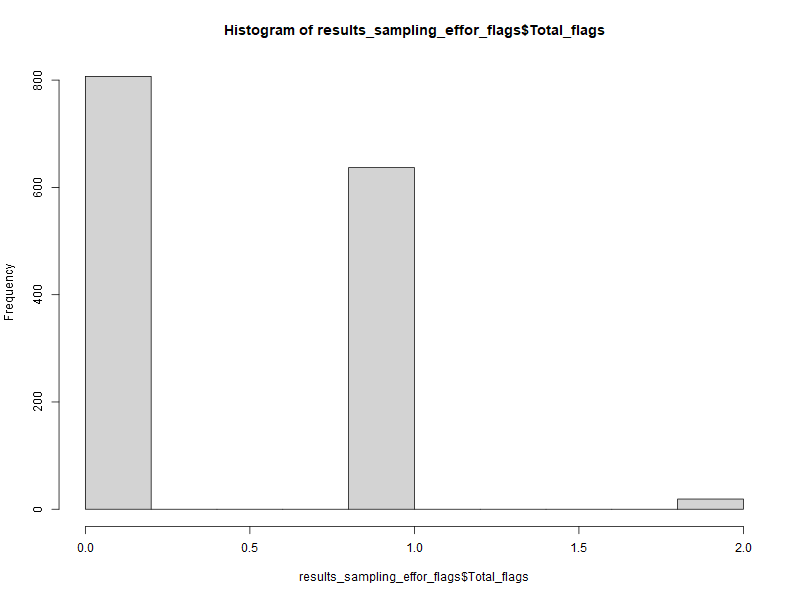

In [179]:
hist(results_sampling_effor_flags$Total_flags)

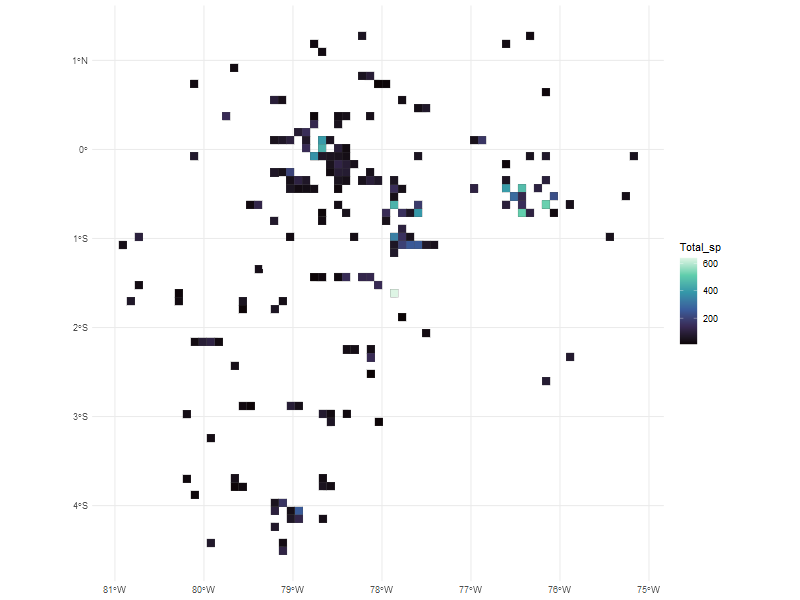

In [ ]:
grid_10km_samping <- grid_10km %>%
  left_join(results_sampling_effor_flags, by = "id_10km") 


grid_10km_samping_filter = grid_10km_samping %>%
  filter(Sampling_coverage>=0.50 )%>%
    filter(Total_records >= 50 )%>%
  filter(Total_sp >= 10)
  

ggplot(grid_10km_samping_filter) +
geom_sf(aes(fill = Total_sp ), color = "grey30", size = 0.1) +
scale_fill_viridis_c(option = "mako") +
theme_minimal()

# 7. Exportar resultados

In [230]:

 st_write(grid_10km_samping, "Results/shp/grid_10km_samping_filter.shp", append=FALSE)

Deleting layer `grid_10km_samping_filter' using driver `ESRI Shapefile'
Writing layer `grid_10km_samping_filter' to data source `Results/shp/grid_10km_samping_filter.shp' using driver `ESRI Shapefile'
Writing 7268 features with 21 fields and geometry type Polygon.


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver
